In [ ]:
import os
import logging

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s [%(levelname)s] %(message)s",
    datefmt="%H:%M:%S"
)


In [ ]:
from spin_system import SpinSystem
from spin_system import interactions

import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt

import json


2025-09-24 12:49:14.512116: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-24 12:49:14.561823: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
def dump_magnetization_json(results, betas, lattice_length, out_dir="../data"):
    # Ensure results is numpy
    results_np = np.array(results["magnetization_evolution"])   # shape (20, 100001)
    betas_np = betas.numpy()         # shape (20,)

    data = {
        f"{beta:.5f}": results_np[i].tolist()
        for i, beta in enumerate(betas_np)
    }
        # Ensure output directory exists
    os.makedirs(out_dir, exist_ok=True)

    # Define path
    out_file = os.path.join(out_dir, f"results_n{lattice_length}.json")


    with open(out_file, "w") as f:
        json.dump(data, f, indent=2)

In [5]:
def create_betas(start, end, focus_start, focus_end, n_total, n_focus):
    focus_points = tf.linspace(focus_start, focus_end, n_focus)

    n_remaining = n_total - n_focus
    outer_points = tf.linspace(start, end, n_remaining)

    betas = tf.sort(tf.concat([focus_points, outer_points], axis=0))
    return betas

I0000 00:00:1758728957.043408   39792 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5563 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


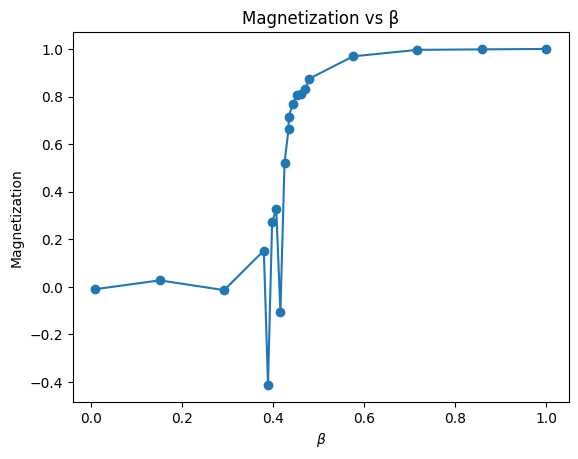

In [ ]:
lattice_dim = 2
sweep_length = 100000
betas = create_betas(0.01, 1, 0.38, 0.48, 20, 12)
for lattice_length in [32]:
    interaction_matrix = interactions.periodic_nn(lattice_dim, lattice_length)
    spin_system = SpinSystem(
        lattice_dim=lattice_dim,
        lattice_length=lattice_length,
        interaction_matrix=interaction_matrix,
        model="ising",
        initial_magnetization=0.5
    )

    # Run multi-temperature sweeps
    results = spin_system.multi_temperature_sweep(
        betas=betas,
        num_disturb=tf.constant(1, dtype=tf.int32),
        sweep_length=sweep_length,
        track_spins=False,
        track_energy=False,
        track_magnetization=True
    )

    magnetizations = results["magnetization_evolution"]

    final_mags = magnetizations[:, -1].numpy()
    plt.plot(betas.numpy(), final_mags, marker='o')
    plt.xlabel(r"$\beta$")
    plt.ylabel("Magnetization")
    plt.title("Magnetization vs β")
    plt.show()

    dump_magnetization_json(results, betas, lattice_length)

In [8]:
# # Run multi-temperature sweeps
# results = spin_system.multi_temperature_sweep(
#     betas=betas,
#     num_disturb=tf.constant(1, dtype=tf.int32),
#     sweep_length=sweep_length,
#     track_spins=False,
#     track_energy=False,
#     track_magnetization=True
# )

# magnetizations = results["magnetization_evolution"]

# final_mags = magnetizations[:, -1].numpy()
# plt.plot(betas.numpy(), final_mags, marker='o')
# plt.xlabel(r"$\beta$")
# plt.ylabel("Magnetization")
# plt.title("Magnetization vs β")
# plt.show()

In [9]:
# lattice_dim = 2
# lattice_length = 30
# sweep_length = 10000
# num_sweeps = range(10)

# start, end = 0.01, 1.0
# focus_start, focus_end = 0.38, 0.48
# n_total, n_focus = 20, 15

# focus_points = tf.linspace(focus_start, focus_end, n_focus)

# n_remaining = n_total - n_focus
# outer_points = tf.linspace(start, end, n_remaining)

# betas = tf.sort(tf.concat([focus_points, outer_points], axis=0))

# num_disturb = 1
# initial_magnetization = 0.5

# interaction_matrix = generate_periodic_nn_coupling_tensor(lattice_dim, lattice_length)

# magnetizations = []

# total_steps = len(betas) * len(num_sweeps)
# step_counter = 0

# for i, beta in enumerate(betas, start=1):
#     ising_spin_system = SpinSystem(
#         lattice_dim=lattice_dim,
#         lattice_length=lattice_length,
#         interaction_matrix=interaction_matrix,
#         model="ising",
#         initial_magnetization=initial_magnetization
#     )

#     logging.info(f"Starting β {i}/{len(betas)} = {beta:.3f}")

#     for j, sweep in enumerate(num_sweeps, start=1):
#         ising_results = ising_spin_system.metropolis_sweep(
#             beta=float(beta),
#             num_disturb=num_disturb,
#             sweep_length=sweep_length,
#             track_spins=False,
#             track_energy=False,
#             track_magnetization=True
#         )

#         step_counter += 1
#         if j % 10 == 0 or j == len(num_sweeps):
#             progress = 100 * step_counter / total_steps
#             logging.info(
#                 f"  Sweep {j}/{len(num_sweeps)} finished "
#                 f"(progress: {progress:.1f}%)"
#             )

#     magnetizations.append(ising_results['magnetization_evolution'][-1].numpy())

# logging.info("Simulation complete. Plotting results...")

# plt.plot(betas, magnetizations, marker='o')
# plt.xlabel(r"$\beta$")
# plt.ylabel("Magnetization")
# plt.title("Magnetization vs β")
# plt.show()
